# Key Point Detection

## SIFT

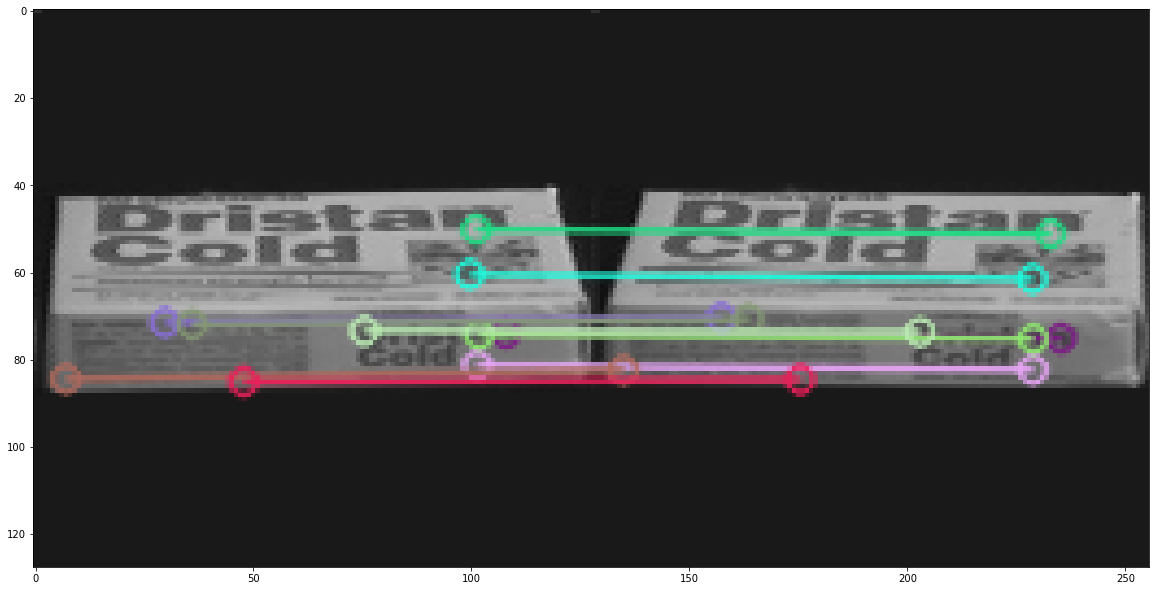

(<matplotlib.image.AxesImage at 0x23a68ae4a00>, None)

In [5]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('first.png')  
img2 = cv2.imread('second.png') 
img3 = cv2.imread('third.png')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

'''
figure, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')
'''

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
keypoints_3, descriptors_3 = sift.detectAndCompute(img3,None)



#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
plt.figure(figsize = (20,20))
plt.imshow(img),plt.show()

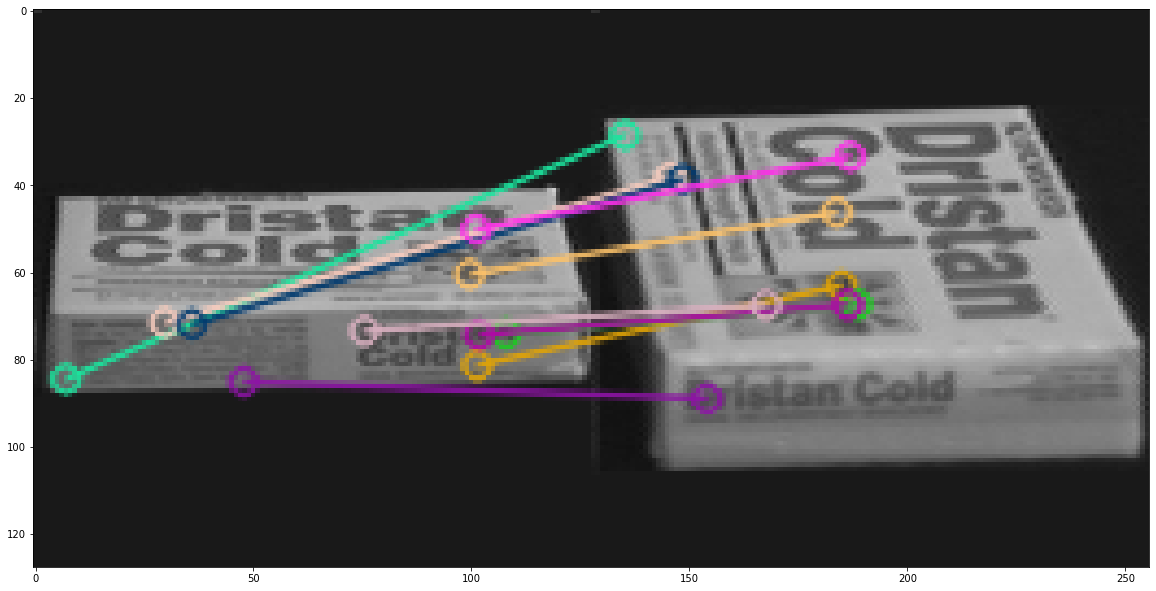

(<matplotlib.image.AxesImage at 0x23a68b3d400>, None)

In [6]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img = cv2.drawMatches(img1, keypoints_1, img3, keypoints_3, matches[:10], img3, flags=2)
plt.figure(figsize = (20,20))
plt.imshow(img),plt.show() 

## ORB

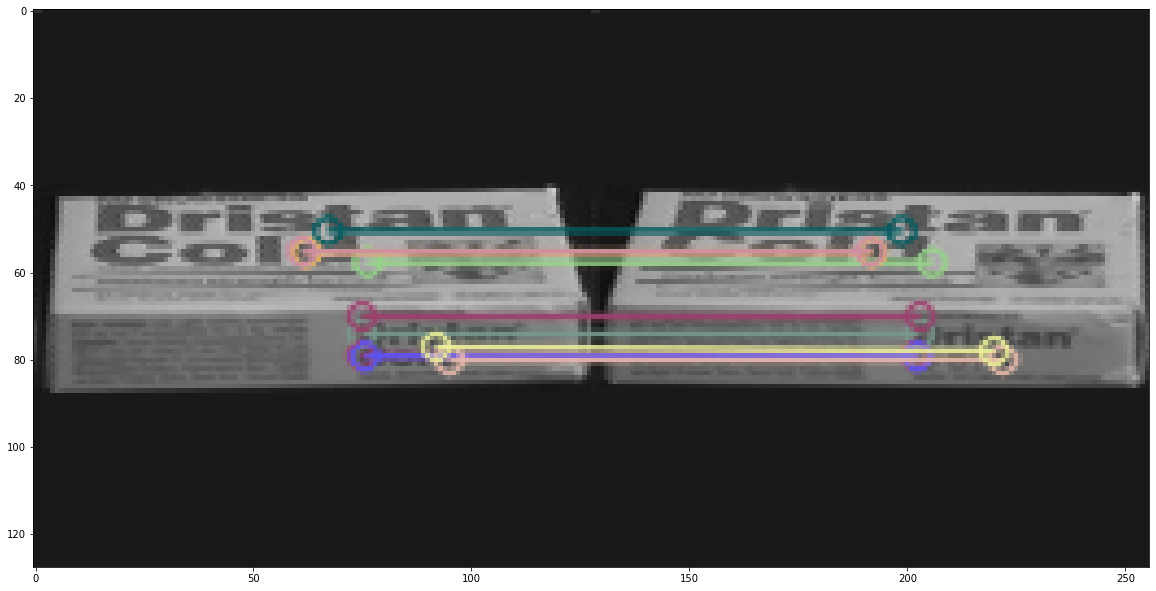

(<matplotlib.image.AxesImage at 0x23a68f1b0a0>, None)

In [7]:

import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

img1 = cv2.imread('first.png')  
img2 = cv2.imread('second.png') 
img3 = cv2.imread('third.png')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(nfeatures=1500)
keypoints_1, descriptors_1 = orb.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = orb.detectAndCompute(img2,None)
keypoints_3, descriptors_3 = orb.detectAndCompute(img3,None)
#feature matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
plt.figure(figsize = (20,20)) 
plt.imshow(img),plt.show()

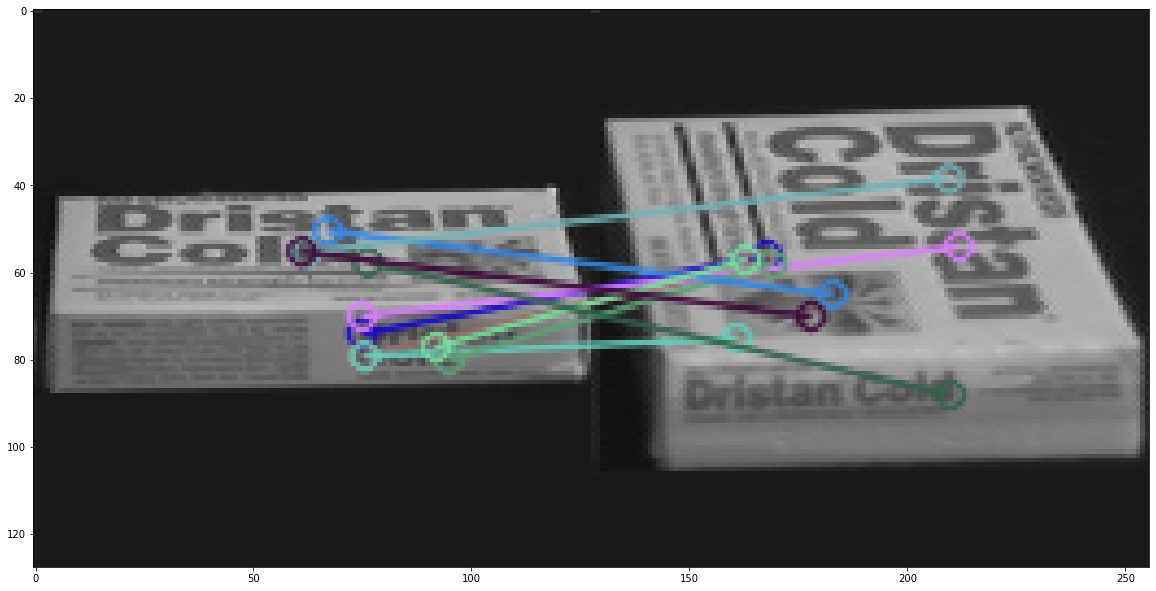

(<matplotlib.image.AxesImage at 0x213c87c2ac0>, None)

In [10]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


m = bf.match(descriptors_1,descriptors_3)
m = sorted(matches, key = lambda x:x.distance)

img = cv2.drawMatches(img1, keypoints_1, img3, keypoints_3, m[:10], img3, flags=2) 
plt.figure(figsize = (20,20))
plt.imshow(img),plt.show() 

## Manhatten Norm

In [1]:
import sys
from imageio import imread
from scipy.linalg import norm
from scipy import sum, average
import numpy as np

In [2]:
def compare_images(img1, img2):
    # normalize to compensate for exposure difference
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))  # Manhattan norm
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    return (m_norm, z_norm)

In [2]:
def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return np.average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

In [4]:
def normalize(arr):
    rng = arr.max()-arr.min()
    if rng == 0:
        rng = 1
    amin = arr.min()
    return (arr-amin)*255/rng


In [5]:
img1 = to_grayscale(imread('coil-100/obj1__0.png').astype(float))
img2 = to_grayscale(imread('coil-100/obj1__10.png').astype(float))
img3 = to_grayscale(imread('coil-100/obj1__100.png').astype(float))
    # compare
n_m, n_0 = compare_images(img1, img2)
print("Manhattan norm:", n_m, "/ per pixel:", n_m/img1.size)
print("Zero norm:", n_0, "/ per pixel:", n_0/img1.size) 

Manhattan norm: 205601.93549249816 / per pixel: 12.548946258087046
Zero norm: 16384.0 / per pixel: 1.0


In [6]:
n_m, n_0 = compare_images(img1, img3) 
print("Manhattan norm:", n_m, "/ per pixel:", n_m/img1.size) 
print("Zero norm:", n_0, "/ per pixel:", n_0/img1.size)

Manhattan norm: 744052.7196813978 / per pixel: 45.413374003991564
Zero norm: 16384.0 / per pixel: 1.0


## FUNDAMENTAL MATRIX

In [8]:
import numpy as np
from skimage import data
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import matplotlib.pyplot as plt
from imageio import imread


def FM(path_1, path_2):
    np.random.seed(0)
    img_left = imread(path_1)
    img_right = imread(path_2)

    #img_left, img_right, groundtruth_disp = data.stereo_motorcycle()
    img_left, img_right = map(rgb2gray, (img_left, img_right))

    # Find sparse feature correspondences between left and right image.

    descriptor_extractor = ORB()

    descriptor_extractor.detect_and_extract(img_left)
    keypoints_left = descriptor_extractor.keypoints
    descriptors_left = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img_right)
    keypoints_right = descriptor_extractor.keypoints
    descriptors_right = descriptor_extractor.descriptors

    matches = match_descriptors(descriptors_left, descriptors_right,
                                cross_check=True)

    # Estimate the epipolar geometry between the left and right image.

    model, inliers = ransac((keypoints_left[matches[:, 0]],
                             keypoints_right[matches[:, 1]]),
                            FundamentalMatrixTransform, min_samples=8,
                            residual_threshold=1, max_trials=5000)

    inlier_keypoints_left = keypoints_left[matches[inliers, 0]]
    inlier_keypoints_right = keypoints_right[matches[inliers, 1]]

    print(f"Number of matches: {matches.shape[0]}")
    print(f"Number of inliers: {inliers.sum()}")

    #plt.figure(figsize = (20,20)) 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,20))

    plt.gray()

    plot_matches(ax, img_left, img_right, keypoints_left, keypoints_right,
                 matches[inliers], only_matches=True)


Number of matches: 77
Number of inliers: 66


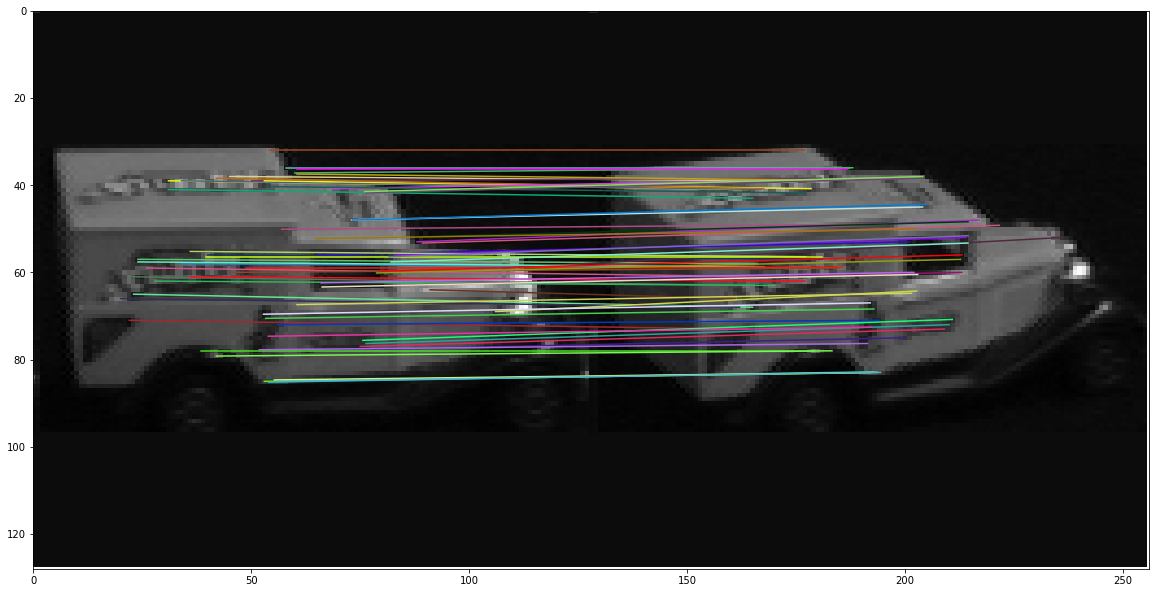

In [9]:
path_1 = 'coil-100/obj100__175.png'
path_2 = 'coil-100/obj100__155.png'

FM(path_1, path_2)

Number of matches: 49
Number of inliers: 21


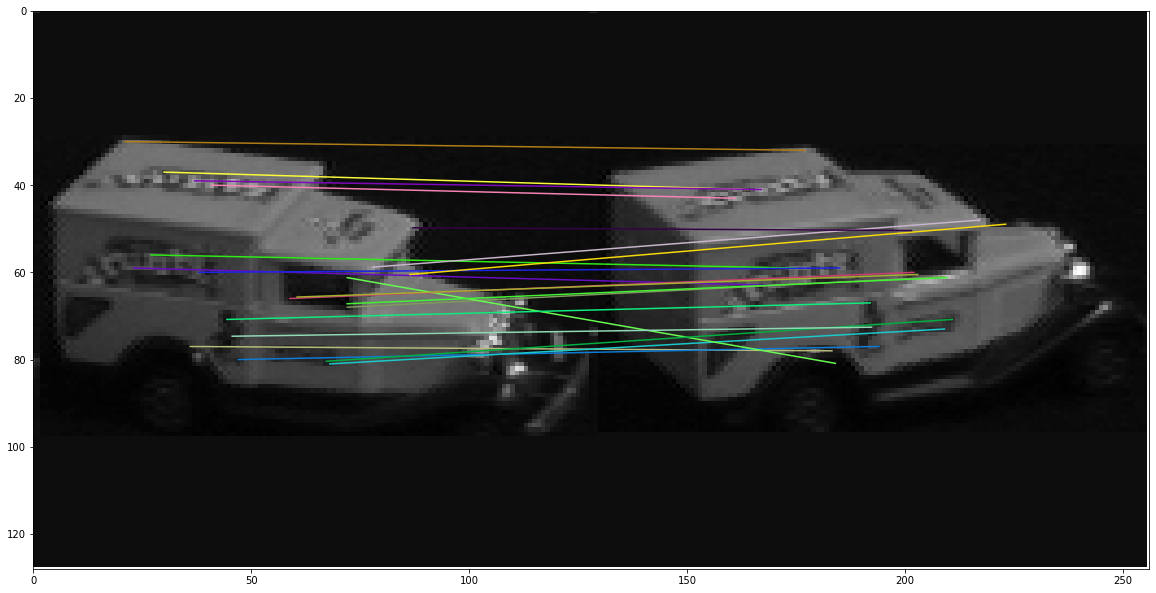

In [10]:
path_1 = 'coil-100/obj100__200.png'
path_2 = 'coil-100/obj100__155.png'

FM(path_1, path_2)

# References

https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf



https://en.wikipedia.org/wiki/Scale-invariant_feature_transform




https://scikit-image.org/docs/stable/auto_examples/transform/plot_fundamental_matrix.html